In [1]:
import PIL as image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# 提取特征
def detect(image):
    # 转化为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 创建SIFT生成器
    # descriptor是一个对象，这里使用的是SIFT算法
    descriptor = cv2.SIFT_create()
    # 检测特征点及其描述符（128维向量）
    kps, features = descriptor.detectAndCompute(image, None)
    return (kps, features)

In [3]:
# 特征匹配
def match_keypoints(kps_left, kps_right, features_left, features_right, ratio, threshold):
    # 建立暴力匹配器
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    # 使用knn检测，匹配left,right图的特征点
    raw_matches = matcher.knnMatch(features_left, features_right, 2)
    print(len(raw_matches))
    matches = []  # 存坐标，为了后面
    good = []  # 存对象，为了后面的演示
    # 筛选匹配点
    for m in raw_matches:
        # 筛选条件
        #         print(m[0].distance,m[1].distance)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            good.append([m[0]])
            matches.append((m[0].queryIdx, m[0].trainIdx))
    # 特征点对数大于4就够用来构建变换矩阵了
    kps_left = np.float32([kp.pt for kp in kps_left])
    kps_right = np.float32([kp.pt for kp in kps_right])
    print(len(matches))
    if len(matches) > 4:
        # 获取匹配点坐标
        pts_left = np.float32([kps_left[i] for (i, _) in matches])
        pts_right = np.float32([kps_right[i] for (_, i) in matches])
        # 计算变换矩阵(采用ransac算法从pts中选择一部分点)
        H, status = cv2.findHomography(pts_right, pts_left, cv2.RANSAC, threshold)
        return (matches, H, good)
    return None

In [4]:
def drawMatches(img_left, img_right, H):
    # 获取图片宽度和高度
    h_left, w_left = img_left.shape[:2]
    h_right, w_right = img_right.shape[:2]
    # 对img进行透视变换
    image = np.zeros((max(h_left, h_right), w_left+w_right, 3), dtype='uint8')
    # 初始化
    image[0:h_left, 0:w_left] = img_right
    # 利用已获得的适应性矩阵进行透视变换
    image = cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))#(w,h
    # 将透视变换后的图片与另一张图片进行拼接
    image[0:h_left, 0:w_left] = img_left
    return image

In [5]:
def main(img_left, img_right, size=(20,20)):
    # 模块一：提取特征
    kps_left, features_left = detect(img_left)
    kps_right, features_right = detect(img_right)
    # 模块二：特征匹配
    matches, H, good = match_keypoints(kps_left,kps_right,features_left,features_right,0.5,0.99)
    # 模块三：透视变换-拼接
    vis = drawMatches(img_left, img_right, H)
    # show
    plt.figure(figsize= size)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.show()

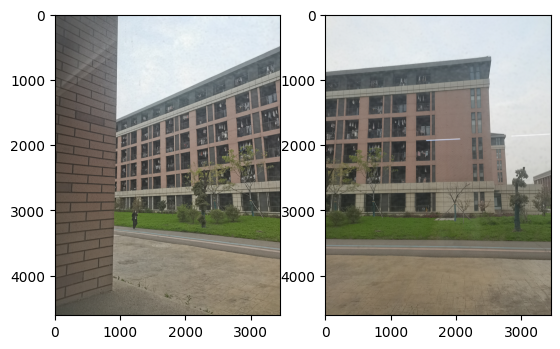

84896
522


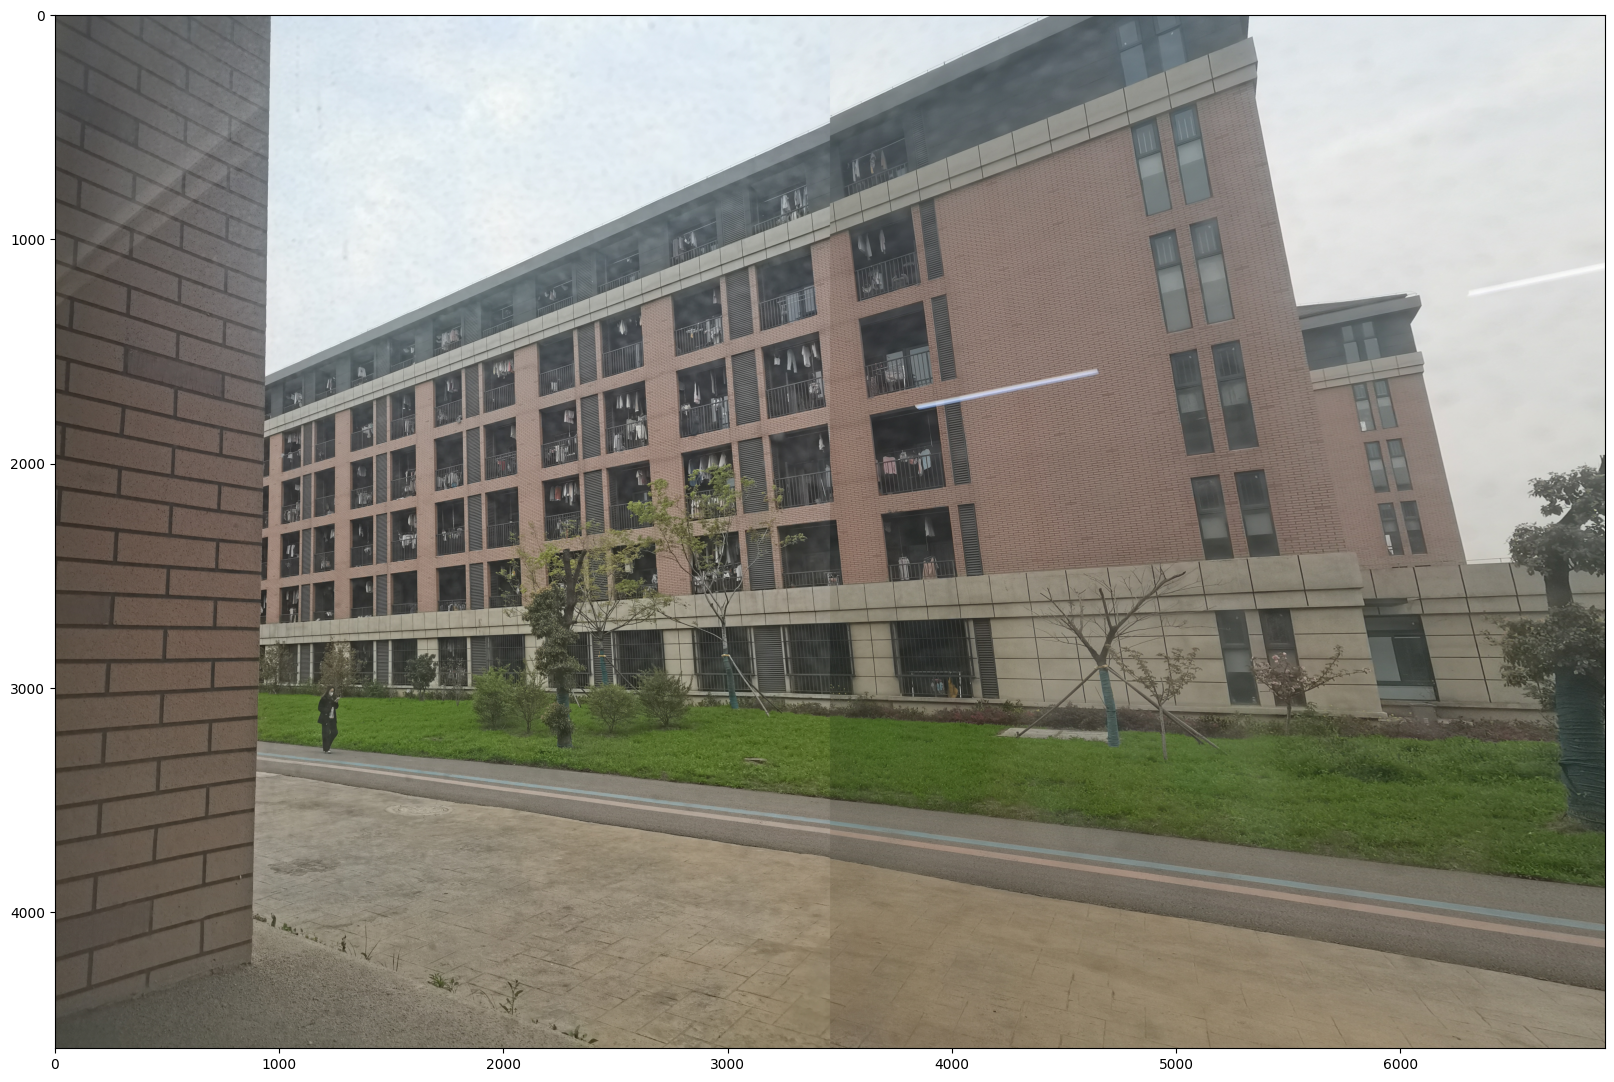

In [6]:
img_left = cv2.imread("../image/img_left.jpg")
img_right = cv2.imread("../image/img_right.jpg")
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.show()
main(img_left, img_right)